# Проект: Статистический анализ данных

**Описание проекта:**

Имеются данные мобильного приложения GoFast о некоторых пользователях из нескольких городов, а также об их поездках на самокатах. Для передвижения по городу, пользователи могут использовать сервис без подписки или с подпиской Ultra.

**Цель проекта:**

Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Описание данных:**

**Пользователи** — users_go.csv

`user_id` - уникальный идентификатор пользователя

`name` - имя пользователя

`age` - возраст

`city` - город

`subscription_type` - тип подписки (free, ultra)

**Поездки** — rides_go.csv

`user_id` - уникальный идентификатор пользователя

`distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)

`duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

`date` - дата совершения поездки

**Подписки** — subscriptions_go.csv

`subscription_type` - тип подписки

`minute_price` - стоимость одной минуты поездки по данной подписке

`start_ride_price` - стоимость начала поездки

`subscription_fee` - стоимость ежемесячного платежа

**Импортируем необходимые библиотеки:**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm 
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

#### Шаг 1. Загрузка данных

In [2]:
users,rides,subscriptions = (pd.read_csv('/datasets/users_go.csv'),
                                pd.read_csv('/datasets/rides_go.csv'),
                                pd.read_csv('/datasets/subscriptions_go.csv'))

##### Посмотрим на представленные таблицы:

**USERS**

In [3]:
users.head(7)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Кол-во строк: 1565

**Изучим пропуски:**

In [5]:
users.isna().sum().sort_values()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

**Посмотрим на явные дубликаты:**

In [6]:
users.duplicated().sum()

31

Дубликатов 31

**Посмотрим на описание числовых значений:**

In [7]:
users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


**RIDES**

In [8]:
rides.head(7)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19


In [9]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Кол-во строк: 18068

**Изучим пропуски:**

In [10]:
rides.isna().sum().sort_values()

user_id     0
distance    0
duration    0
date        0
dtype: int64

**Посмотрим на явные дубликаты:**

In [11]:
rides.duplicated().sum()

0

Дубликатов 0

**Посмотрим на описание числовых значений:**

In [12]:
rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


**SUBSCRIPTIONS**

In [13]:
subscriptions.head(7)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [14]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Кол-во строк: 2

**Изучим пропуски:**

In [15]:
subscriptions.isna().sum().sort_values()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Посмотрим на явные дубликаты:**

In [16]:
subscriptions.duplicated().sum()

0

Дубликатов 0

**Посмотрим на описание числовых значений:**

In [17]:
subscriptions.describe()

,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


##### Промежуточный вывод:

Итого мы имеем 3 датафрейма: **пользователи(users)**, **поездки(rides)**, **подписки(subscriptions)**

Таблица **users**:

* Тип данных корректный, пропуски отсутствуют, имеется 31 явный дубликат.

* Судя по столбцу **age**, медианные значения почти совподают(**25** и **24.9**). 75% пользователей имеют возраст до **28 лет**.

Таблица **rides**:

* Необходимо поменять тип данных столбца поездки на **datetime**, пропуски отсутствуют, явные дубликаты отсутствуют
* Минимальное расстояние поездки - **0.86м.**
* Среднее расстояние поездки - **3км.**
* Средняя продолжительность поездок - **18 мин.**


Таблица **subscriptions**:

* Тип данных корректный, пропуски отсутствуют, явные дубликаты отсутствуют
* **без подписки**(**free**) стоимость минуты поездки - **8 руб.**, стоимость начала поездки - **50 руб.**, абонентская плата - **отсутствует**
* по подписке **ultra** стоимость минуты поездки - **6руб.**, стоимость начала поездки - **бесплатно**, абонентская плата - **199руб/мес**

#### Шаг 2. Предобработка данных

##### Наведём порядок в данных

**Приведем столбец date таблицы rides к корректному типу:**

In [18]:
rides['date'] = pd.to_datetime(rides['date']).dt.date

In [19]:
rides['date']

0        2021-01-01
1        2021-01-18
2        2021-04-20
3        2021-08-11
4        2021-08-28
            ...    
18063    2021-11-04
18064    2021-11-16
18065    2021-11-18
18066    2021-11-27
18067    2021-12-29
Name: date, Length: 18068, dtype: object

**Посмотрим на разброс дат:**

In [20]:
print('Минимальная дата:', rides['date'].min())
print('Максимальная дата:',  rides['date'].max())

Минимальная дата: 2021-01-01
Максимальная дата: 2021-12-30


Получается, что исследуемый год  - **2021**

Добавим отдельный столбец  с номером месяца:

In [21]:
rides['month'] =pd.to_datetime(rides['date']).dt.month
rides

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


**Убираем явные дубликаты в users**

In [22]:
users.drop_duplicates(inplace=True)
users.duplicated().sum()

0

##### Расширим наблюдения из выводов

**Посмотрим на распределение продолжительности поездок и расстояния оных(за 1 поездку)**:

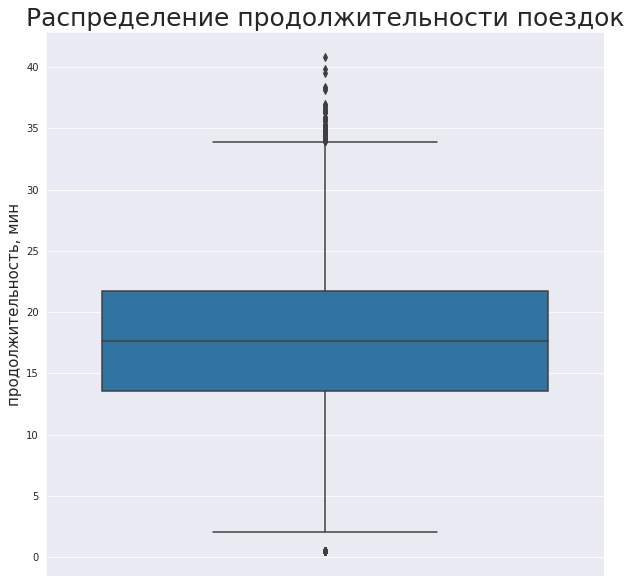

In [23]:
plt.figure(figsize=(10,10))
sns.set_style("darkgrid")
_ = sns.boxplot(y='duration',data=rides)
_.axes.set_title('Распределение продолжительности поездок',fontsize=25,loc ='center')
_.set_xlabel('')
_.set_ylabel('продолжительность, мин', fontsize=15)
plt.show()

Судя по графику основная масса поездок, сосредоточилась в диапазоне **15-23 мин**, также наблюдаются выбросы **менее 2 мин.** и **более 35 мин.** 

**Изучим выбросы:**

**Более подробно глянем на строки с продолжительностью менее 2х мин**:

In [24]:
rides.query('duration < 2')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


In [25]:
rides.query('duration < 2')['distance'].min()

4030.308008428866

**Посмотрим, какой процент данных менее 2х мин.**:

In [26]:
x =95/18068*100 #делим строки менее 2х минут на общее количество строк в rides и ум ножаем на 100
x

0.5257914545052026

Получается эти данные составляют **менее 1%**

В итоге, в **rides** присутствует **95 строк** с продолжительностю поездки **менее 2х мин.**, при этом минимальное расстояние **4030м(+-4км)**, следовательно вкралась какая-то ошибка. Возможно во время поездки "забаговался" счётчик продолжительности сессии. Поскольку корректную продолжительность сессии указать не представляется возможным, **опустим** эти данные, дабы не искажать последущее исследование.

In [27]:
rides.drop(index=rides.query('duration < 2').index, inplace=True)

**Более подробно глянем на строки с продолжительностью более 35 минут**

In [28]:
rides.query('duration > 35')

,user_id,distance,duration,date,month
42,4,4649.488243,35.896929,2021-08-14,8
143,15,4187.621459,38.125729,2021-01-13,1
499,55,4151.081878,36.906491,2021-06-30,6
524,58,4763.920660,35.819603,2021-02-17,2
854,91,4444.579979,35.222900,2021-11-05,11
1111,119,4060.082639,35.360496,2021-05-15,5
1455,158,3967.285849,35.803715,2021-05-09,5
1621,174,3794.401307,35.766408,2021-12-23,12
1694,183,4473.798120,36.402535,2021-01-02,1
1894,205,4218.386189,36.310317,2021-08-26,8


Тут тяжело предположить причины такой длительной сессии. Может быть всё что угодно: низкая скорость, остановки, случайно незавершённая сессия и тп. Поэтому оставим данные без изменений.

**Изучим расстояние за сессию**:

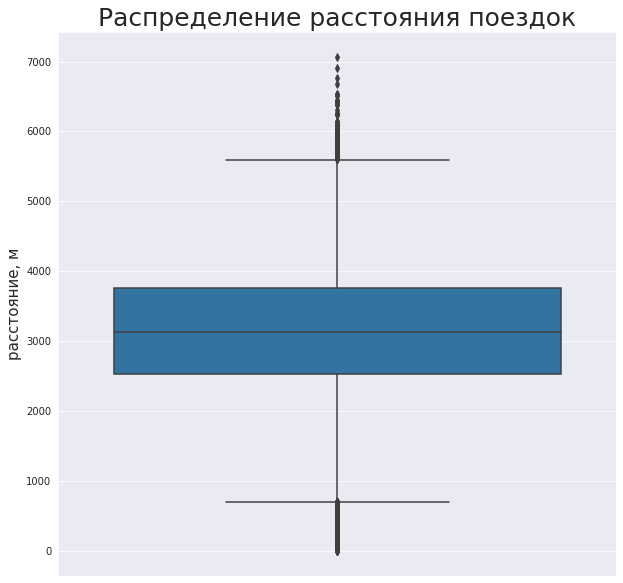

In [29]:
plt.figure(figsize=(10,10))
sns.set_style("darkgrid")
_ = sns.boxplot(y='distance',data=rides)
_.axes.set_title('Распределение расстояния поездок',fontsize=25, loc ='center')
_.set_xlabel('')
_.set_ylabel('расстояние, м', fontsize=15)
plt.show()

Основная масса поездок от **2500 м.** до **4000 м.** Выбросы присутствуют в районе **менее 600 м.** и **более 5600 м.**

**Изучим выбросы:**

**Посмотрим на строки с расстоянием менее 600 м.**

In [30]:
rides.query('distance < 600')

,user_id,distance,duration,date,month
197,21,518.341543,10.151870,2021-02-03,2
204,21,517.912395,14.219625,2021-10-01,10
228,24,409.829089,10.294197,2021-04-04,4
406,44,504.654111,4.513962,2021-01-25,1
463,50,307.532350,6.230129,2021-08-05,8
...,...,...,...,...,...
18007,1531,450.981518,15.591699,2021-02-14,2
18018,1531,375.107762,5.406654,2021-06-27,6
18031,1532,303.787850,7.792490,2021-05-21,5
18043,1533,310.488247,10.642389,2021-02-21,2


**Посмотрим, какой процент данных менее 600 м.:**

In [31]:
x=728/18068*100
x

4.02922293557671

Получается эти данные составляют **4%**

Причины по кеоторым пользователи ехали на самокате **менее 600 м.** могут быть разные(может торопились куда-то). Поскольку нас болше интересует **продолжительность** поездок, нежели их **расстояние** оставим данные без изменений, тем более, что таких данных **менее 5%** .

**Посмотрим на строки с расстоянием более 5600 м.**

In [32]:
rides.query('distance > 5600')

,user_id,distance,duration,date,month
6312,677,5699.769662,18.213792,2021-03-12,3
6549,702,5924.120648,21.156693,2021-11-19,11
6754,716,5835.527411,20.506582,2021-11-05,11
6788,719,5648.444936,19.837195,2021-10-13,10
7026,736,5787.742203,15.890581,2021-02-09,2
...,...,...,...,...,...
17389,1488,5630.700924,24.356457,2021-06-12,6
17418,1490,5830.284286,20.660569,2021-01-22,1
17681,1508,5600.052517,19.586316,2021-11-14,11
17773,1514,6039.465068,26.421033,2021-09-28,9


**Посмотрим, какой процент данных более 5600 м.:**

In [33]:
x=115/18068*100
x

0.6364843922957716

Получается эти данные составляют **менее 1%**

Ситуация аналогичная предыдущей, оставим без изменений.

**Обновим индексы**:

In [34]:
rides.reset_index(drop=True, inplace = True)

**Округлим продолжительность поездок до целого числа**:

In [35]:
rides['duration'] = np.ceil(rides['duration'])
rides['duration']

0        26.0
1        16.0
2         7.0
3        19.0
4        27.0
         ... 
17968    20.0
17969    22.0
17970    19.0
17971    17.0
17972    16.0
Name: duration, Length: 17973, dtype: float64

##### Промежуточный вывод

**В ходе предобработки данных:**

* привели столбец **date** таблицы **rides** к **datetime** 
* удалены явные дубликаты из таблицы **users**
* удалены выбивающиеся значения из таблицы **rides**
* округлён продолжительности поездок
* в таблицу **rides** добавлен столбец с номером месяца поездки.

#### Шаг 3. Исследовательский анализ данных

# Частота встречаемости городов

**Для начала посмотрим на представленные города:**

In [36]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

**Построим график распределения пользователей по городам для наглядности:**

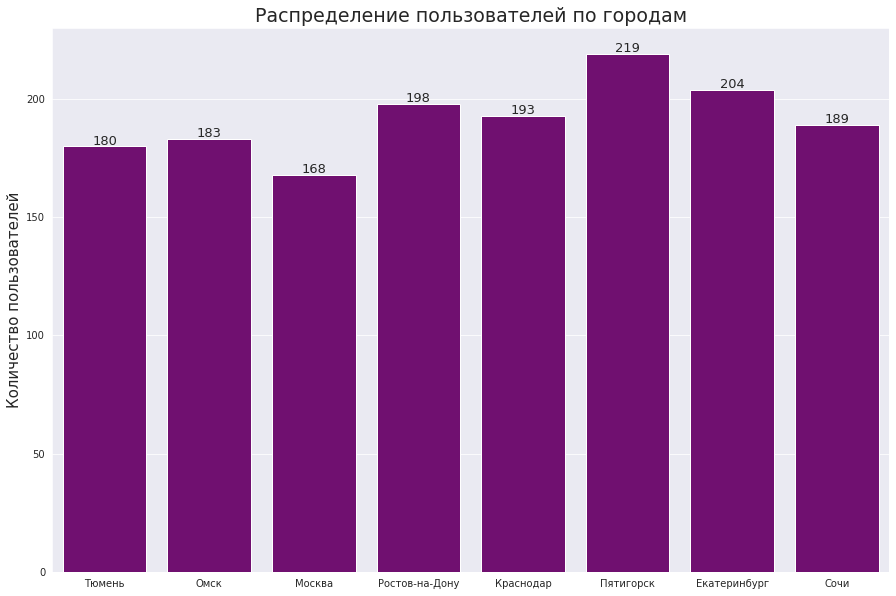

In [37]:
city_order = ['Тюмень','Омск','Москва','Ростов-на-Дону','Краснодар','Пятигорск','Екатеринбург','Сочи']

countplt, ax = plt.subplots(figsize = (15, 10))
ax = sns.countplot(x= 'city', data=users, order = city_order, color = 'purple')
ax.set_title('Распределение пользователей по городам', fontsize = 19, loc ='center')
ax.set_xlabel('')
ax.set_ylabel('Количество пользователей', fontsize = 15)
for rect in ax.patches:
        ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 13)
plt.show()


**Расположим их в порядке убывания для нагляджности**

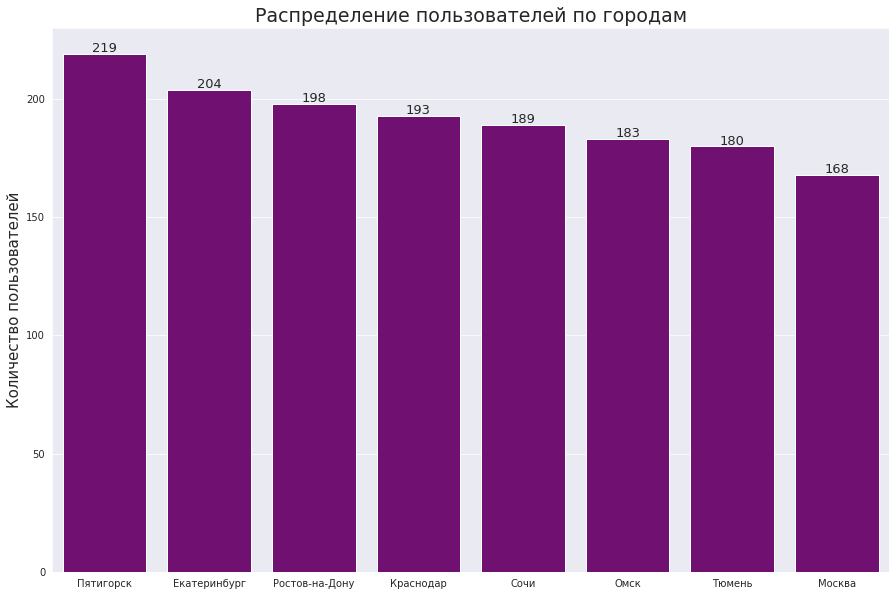

In [38]:
city_order = ['Пятигорск', 'Екатеринбург', 'Ростов-на-Дону', 'Краснодар', 'Сочи', 'Омск', 'Тюмень', 'Москва']

countplt, ax = plt.subplots(figsize = (15, 10))
ax = sns.countplot(x= 'city', data=users, order = city_order, color = 'purple')
ax.set_title('Распределение пользователей по городам', fontsize = 19, loc ='center')
ax.set_xlabel('')
ax.set_ylabel('Количество пользователей', fontsize = 15)
for rect in ax.patches:
        ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 13)
plt.show()

**Посмотрем в разрезе долей**

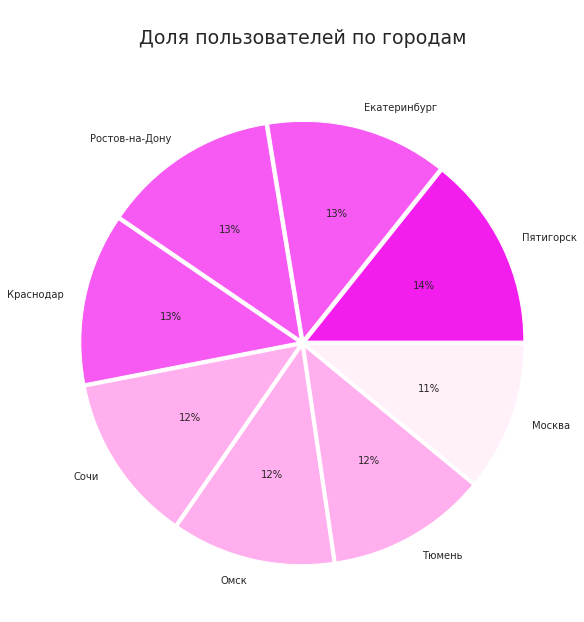

In [39]:
(users['city']
 .value_counts()
 .plot(kind='pie', figsize=(10,10), autopct='%1.0f%%',
       explode=(0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02),
       colors = ['#F31DED','#F65AF2','#F65AF2','#F65AF2', '#FFAFED','#FFAFED','#FFAFED','#FFF0FA'])
)
plt.title('\nДоля пользователей по городам\n', fontsize = 19, loc ='center')
plt.ylabel('')
plt.show()

**Исходя из графиков, можно сделать выводы:** 
* cреди городвов наблюдается разброс, как количественно, так и в долях
* самый популярный город - Пятигорск(**219** пользователей, **14%** от общего кол-ва)
* самый непопулярный город - Москва(**168** пользователей, **11%** от общего кол-ва)

# Соотношение пользователей с подпиской и без подписки

In [40]:
users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

**Как мы уже знаем есть 2 типа пользователей:**
    
 * **ultra**(с подпиской)
 * **free**(без подписки)

**Посмотрим на количественный параметр**:

In [41]:
users["subscription_type"].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

Итак, пользователей с подпиской **699**, пользователей без подписки **835**

**Посмотрим на соотношение:**

In [42]:
x = 835/(835+699)*100
x

54.43285528031291

In [43]:
y = 699/(835+699)*100
y

45.56714471968709

Получается, что пользователей с **без подписки** - **54%**, пользователей **с подпиской** - **46%**

**Визуализируем полученные результаты:**

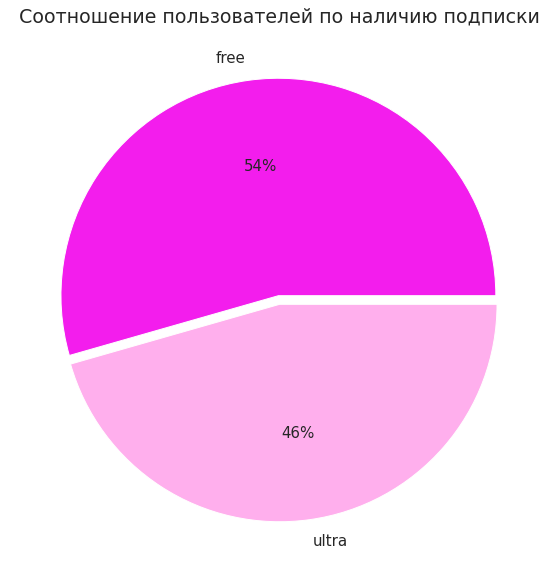

In [44]:
(users['subscription_type']
 .value_counts()
 .plot(kind='pie', figsize=(10,10), autopct='%1.0f%%',
       explode=(0.02, 0.02), textprops = {"fontsize":15},
       colors = ['#F31DED','#FFAFED'])
)
plt.title('Соотношение пользователей по наличию подписки', fontsize = 19, loc ='center')
plt.ylabel('')
plt.show()

**Итого:**
* пользователей с подпиской - **699(46%)**
* пользователей без подпсики - **835(54%)**

# Возраст пользователей

**Посмотрим на распределение пользователей по возрасту**:

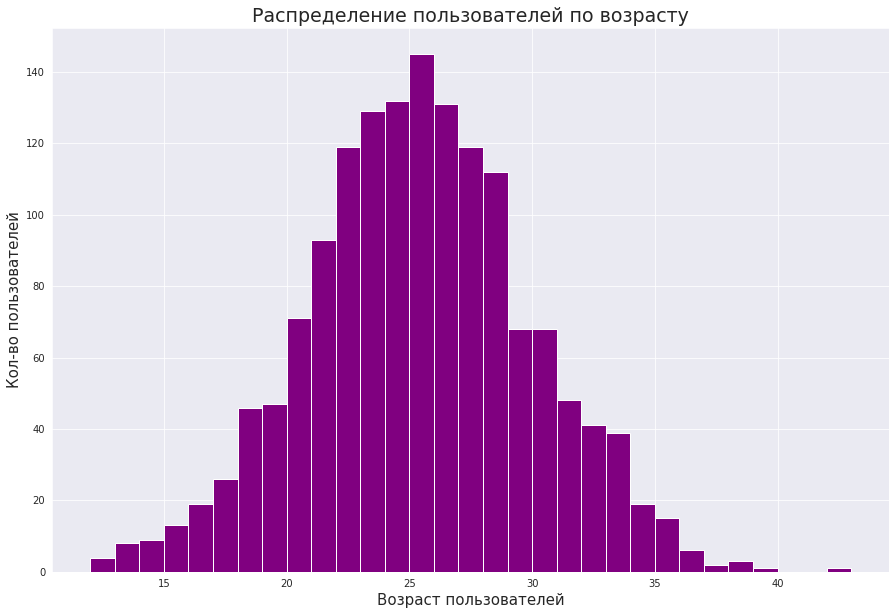

In [45]:
plt.figure(figsize=(15,10))
sns.histplot(data = users, x = 'age', color = 'purple', alpha = 1, binwidth = 1)
plt.title('Распределение пользователей по возрасту', fontsize=19, loc ='center')
plt.xlabel('Возраст пользователей', fontsize = 15)
plt.ylabel('Кол-во пользователей', fontsize = 15)
plt.show()

**Всё как мы и писали ранее**:

 * средний возраст пользователей - **25 лет**
 * самый молодой пользователь - **12 лет**
 * самый старший пользователь - **43 года**
 * больше всего пользоватлей от **12 до 26 лет**.

# Расстояние, которое пользователь преодалел за одну поездку

**Посмотрим на распределение расстояний поездок по пользователям**:

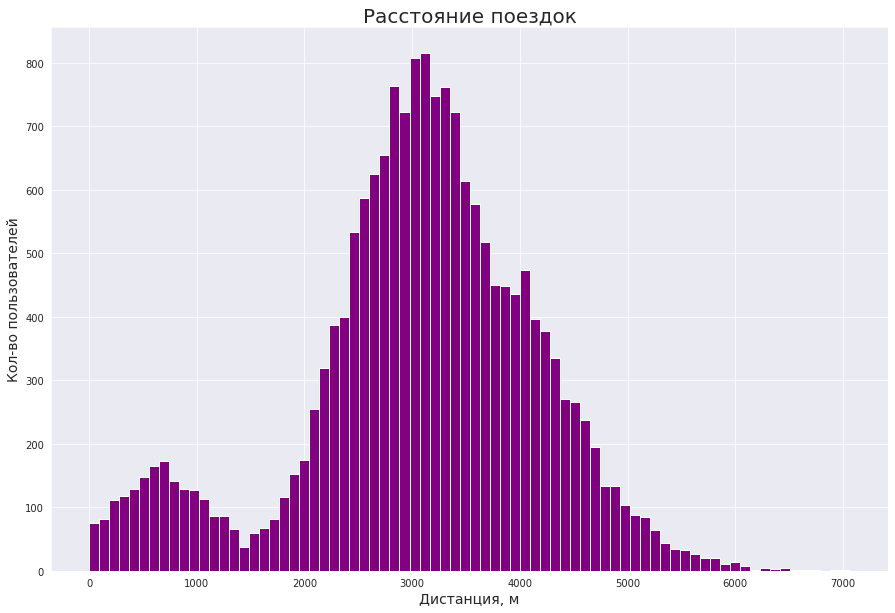

In [46]:
plt.figure(figsize=(15,10))
sns.histplot(data = rides, x = 'distance', color = 'purple', alpha = 1)
plt.title('Расстояние поездок', fontsize = 20, loc ='center')
plt.xlabel('Дистанция, м', fontsize = 14)
plt.ylabel('Кол-во пользователей', fontsize = 14)
plt.show()

**Видим следущее:**

* Самое часто-пройденное расстояние - от **2500м.** до **3500м.**
* Пользователи часто арендуют самокат для коротких поездок(**1500м.**)

# Продолжительность поездок

**Посмотрим на продолжительность поездок пользователей**:

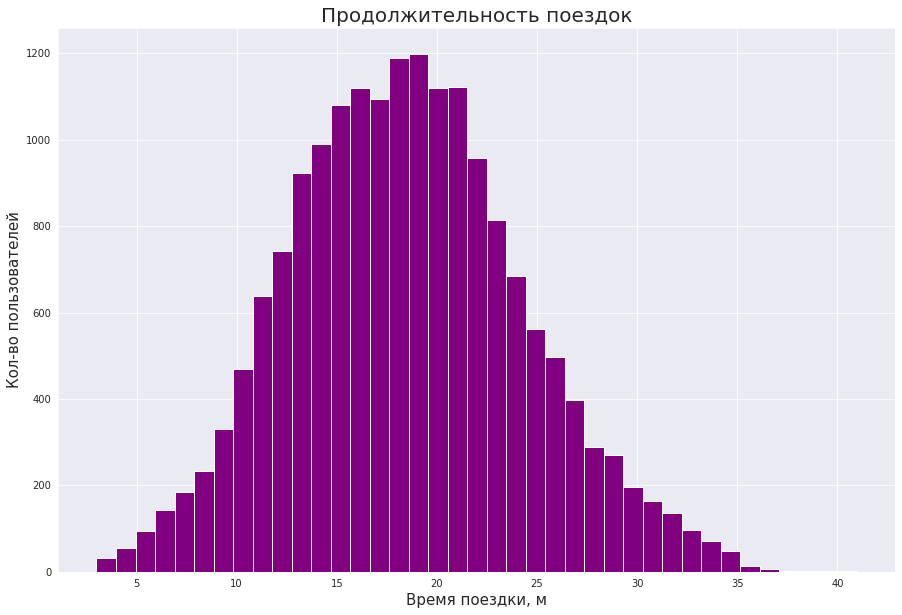

In [47]:
plt.figure(figsize=(15,10))
sns.histplot(data = rides, x = 'duration', color='purple', alpha = 1, bins = 39)
plt.title('Продолжительность поездок', fontsize = 20, loc ='center')
plt.xlabel('Время поездки, м', fontsize = 15)
plt.ylabel('Кол-во пользователей', fontsize = 15)
plt.show()

**Видим следущее:**

* чаще всего присутствуют сессии от **15 мин.** до **21 мин.**
* кол-во поездок менее **8 мин** и более **30 мин** незначительно
* максимальная продолжительность сессии - **41 мин**

##### Промежуточный вывод

* Самый популярный город - Пятигорск(**219** пользователей, **14%** от общего кол-ва)
* Самый непопулярный город - Москва(**168** пользователей, **11%** от общего кол-ва)
* Пользователей с подпиской - **699(46%)**
* Пользователей без подпсики - **835(54%)**
* Средний возраст пользователей - **25 лет**
* Самый молодой пользователь - **12 лет**
* Самый старший пользователь - **43 года**
* Больше всего пользоватлей от **12 до 26 лет**.
* Самое часто-пройденное расстояние - от **2500м.** до **3500м.**
* Чаще всего присутствуют сессии от **15 мин.** до **21 мин.**
* Максимальная продолжительность сессии - **41 мин**

#### Шаг 4. Объединение данных

**Объеденим данные о пользователях, поездках и подписках в один датафрейм**

In [48]:
full_data = users.merge(rides, on = 'user_id')
full_data = full_data.merge(subscriptions, on = 'subscription_type')
display(full_data.sample(5))
full_data.info()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
10253,977,Амалия,22,Москва,free,2163.486458,11.0,2021-05-05,5,8,50,0
1839,198,Марсель,27,Сочи,ultra,3617.383999,18.0,2021-11-02,11,6,0,199
11338,1056,Милена,27,Пятигорск,free,3774.374245,22.0,2021-12-01,12,8,50,0
2126,227,Вячеслав,22,Москва,ultra,3037.551831,16.0,2021-07-02,7,6,0,199
1836,198,Марсель,27,Сочи,ultra,3632.046268,22.0,2021-09-21,9,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            17973 non-null  int64  
 1   name               17973 non-null  object 
 2   age                17973 non-null  int64  
 3   city               17973 non-null  object 
 4   subscription_type  17973 non-null  object 
 5   distance           17973 non-null  float64
 6   duration           17973 non-null  float64
 7   date               17973 non-null  object 
 8   month              17973 non-null  int64  
 9   minute_price       17973 non-null  int64  
 10  start_ride_price   17973 non-null  int64  
 11  subscription_fee   17973 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 1.8+ MB


**Посмотрим на состав таблицы**:

In [49]:
print(f'в таблице users \033[1;30m{users.shape[0]}\033[0m строк и \033[1;30m{users.shape[1]}\033[0m столбцов\
        \nв таблице rides \033[1;30m{rides.shape[0]}\033[0m строк и \033[1;30m{rides.shape[1]}\033[0m столбцов\
        \nв таблице subscriptions \033[1;30m{subscriptions.shape[0]}\033[0m строк и \033[1;30m{subscriptions.shape[1]}\033[0m столбцов\
        \nв таблице full_df \033[1;30m{full_data.shape[0]}\033[0m строк и \033[1;30m{full_data.shape[1]}\033[0m столбцов')

в таблице users 1534 строк и 5 столбцов        
в таблице rides 17973 строк и 5 столбцов        
в таблице subscriptions 2 строк и 4 столбцов        
в таблице full_df 17973 строк и 12 столбцов


**Итого:**

* максимальное кол-во строк в **rides**(**17973**)
* всего столбцов - **15**

**Создадим 2 датафрейма с данными о пользователях по наличию подписки**

In [50]:
data_free = full_data.query('subscription_type == "free"')
data_ultra = full_data.query('subscription_type == "ultra"')
data_free

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


In [51]:
data_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,25.0,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,16.0,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,15.0,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,16.0,2021-10-17,10,6,0,199


**Визуализируем полученные данные**:

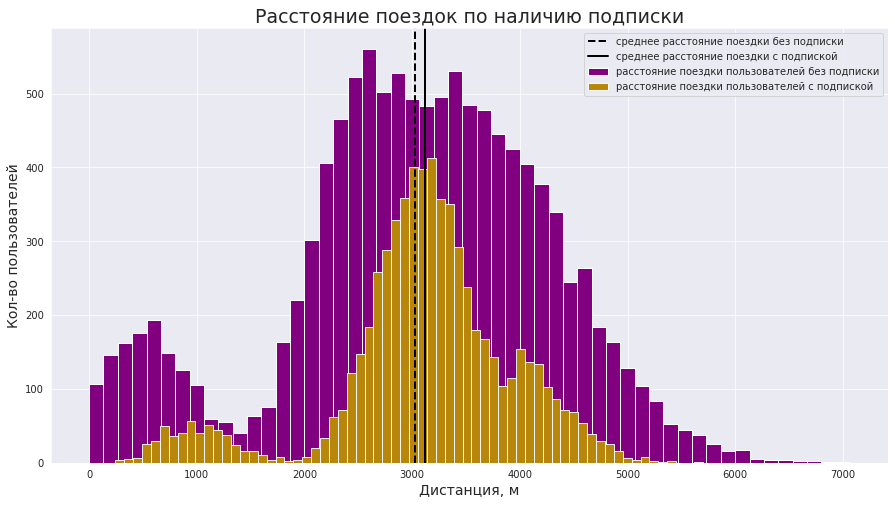

In [52]:
plt.figure(figsize=(15,8))
sns.histplot(data = data_free, x = 'distance', color = 'purple',alpha = 1, label='расстояние поездки пользователей без подписки')
sns.histplot(data = data_ultra, x = 'distance', color = 'darkgoldenrod',alpha = 1, label='расстояние поездки пользователей с подпиской')
plt.axvline(data_free['distance'].mean(), c='k', ls='--', lw=2, label='среднее расстояние поездки без подписки')
plt.axvline(data_ultra['distance'].mean(), c='k', ls='-', lw=2, label='среднее расстояние поездки с подпиской')
plt.title('Расстояние поездок по наличию подписки',fontsize = 19, loc ='center')
plt.xlabel('Дистанция, м', fontsize = 14)
plt.ylabel('Кол-во пользователей', fontsize = 14)
plt.legend()
plt.show()

Как мы уже ранее замечалии, кол-во пользователй без абонемента больше. В начале распределения у обеих категорий мы наблюдаем "хребты", для пользователей **без подписки** эти значения лежат в диапазоне от **0** до **1500 м.**, для пользователей **с подпиской** - от **200м.** до **2000 м.**, можно предположить, что это расстояние до метро, общественного транспорта или до работы. Далее пользователи **без подписки** пользуются самокатами в более широком диапазоне с пиковыми значениями в районе **2500м.** - **3500м.**, тогда как расстояние пользователей с подпиской более скорцентрированно в районе **3000м.** Также стоит отметить, что максимальная дистанция у пользователей **с подпиской** - чуть более **5000м.**, а у пользователей **без подписки** - **более 6000м.** Среднее расстояние пользователей **с подпиской** немного длиннее среднего расстояния пользователей **без подписки**.

**Посмотрим плотность распределения расстояния поездок**:

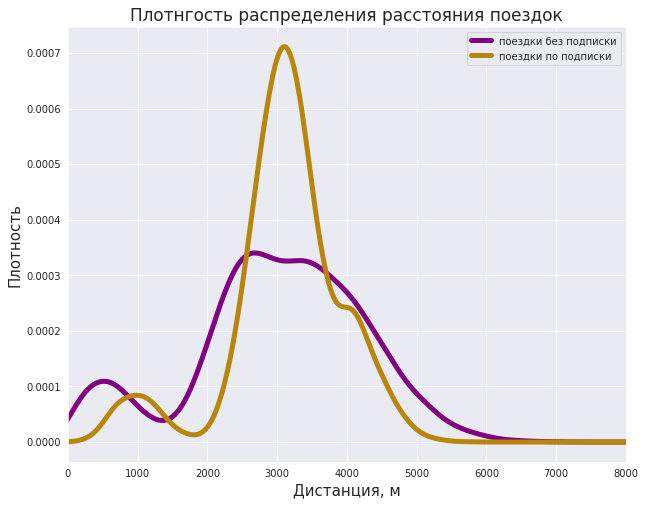

In [53]:
plt.figure(figsize=(10,8))
data_free.distance.plot.density(color = 'purple', linewidth = 5, label = 'поездки без подписки')
data_ultra.distance.plot.density(color = 'darkgoldenrod', linewidth = 5, label = 'поездки по подписки')
plt.xlim([0,8000])
plt.legend()
plt.title('Плотнгость распределения расстояния поездок', fontsize = 17, loc ='center')
plt.xlabel('Дистанция, м', fontsize = 15)
plt.ylabel('Плотность', fontsize = 15)
plt.show()

**Итого:**

* пользователи **с подпиской** чаще всего используют самокаты на поездки около **3000 м**
* пользователи **без подписки** используют самокаты для поездок более широкого диапазона и менее сконцентрированно

**Посмотрим на продолжительность поездок по наличию подписки**:

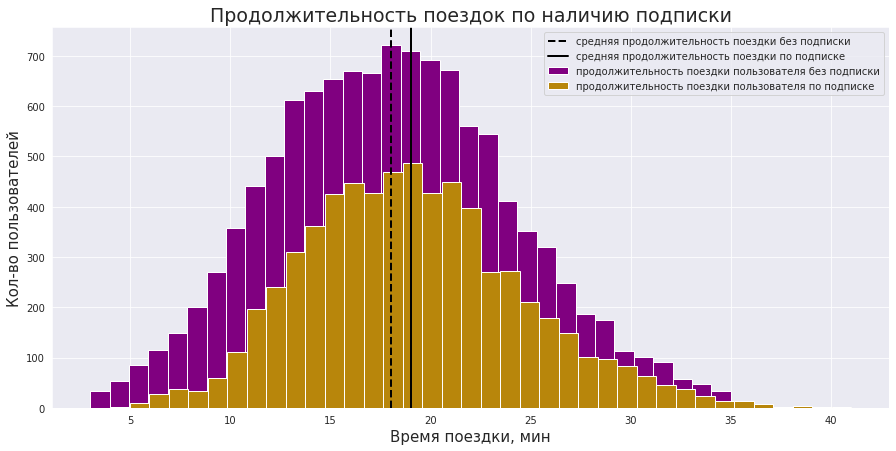

In [54]:
plt.figure(figsize=(15,7))
sns.histplot(data = data_free, x = 'duration', color = 'purple', alpha = 1, bins=33, label = 'продолжительность поездки пользователя без подписки')
sns.histplot(data = data_ultra, x = 'duration', color = 'darkgoldenrod', alpha = 1, bins=38, label = 'продолжительность поездки пользователя по подписке')
plt.axvline(data_free['duration'].mean(), c='k',ls='--', lw=2, label='средняя продолжительность поездки без подписки')
plt.axvline(data_ultra['duration'].mean(), c='k',ls='-', lw=2, label='средняя продолжительность поездки по подписке')
plt.legend()
plt.title('Продолжительность поездок по наличию подписки', fontsize = 19, loc ='center')
plt.xlabel('Время поездки, мин', fontsize = 15)
plt.ylabel('Кол-во пользователей', fontsize = 15)
plt.show()

**На данном графике всё без сюрпризов:** 

* для обеих категорий пиковые значения продолжительности поездки в районе **20 мин** 
* средняя продолжительность клиентов **с подпиской** немного превышает продолжительность поездки пользователей **без подписки**

**Посмотрим на плотность распределения длительности поездки.**

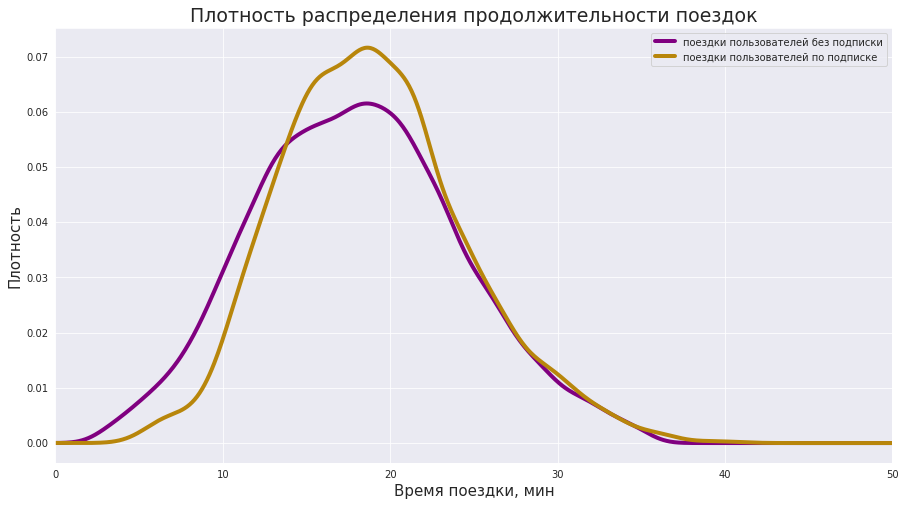

In [55]:
plt.figure(figsize=(15,8))
data_free.duration.plot.density(color='purple', linewidth=4, label='поездки пользователей без подписки')
data_ultra.duration.plot.density(color='darkgoldenrod', linewidth=4, label='поездки пользователей по подписке')
plt.xlim([0, 50])
plt.title('Плотность распределения продолжительности поездок',fontsize = 19, loc ='center')
plt.xlabel('Время поездки, мин', fontsize = 15)
plt.ylabel('Плотность', fontsize = 15)
plt.legend()
plt.show()

**Итого:**

* у пользователей **с подпиской** более ярко выражены поездки протяженностью **15-20 мин.**
* пользователи **без подписки** чаще берут самокат на короткие интервалы

##### Промежуточный вывод

**Проделанная работа:** 
  * объединили данные о пользователях, поездках и подписках в один датафрейм
  * разделили датафрейм по наличию подписки
  *  визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий

**Итоги:**
  * чаще всего пользователи без подписки проезжают на самокатах от **2500м.** до **3500м.**
  * по продолжительности поездок графики обеих категорий различаются незначительно
  * пиковое значение приходится на **20 мин**
  * пользователи **без подписки** чаще берут самокат на короткие интервалы

#### Шаг 5. Подсчёт выручки

**Для каждого пользователя рассчитаем суммарное расстояние, количество поездок и суммарное время за каждый месяц**

In [56]:
rev_data = (full_data
           .groupby(['user_id', 'month'])
           .agg(
               count = ('user_id','count'),
               distance = ('distance','sum'),
               duration=('duration', 'sum'),
               sub_type = ('subscription_type', 'first'))
            .reset_index()
)
rev_data

,user_id,month,count,distance,duration,sub_type
0,1,1,2,7027.511294,42.0,ultra
1,1,4,1,754.159807,7.0,ultra
2,1,8,2,6723.470560,46.0,ultra
3,1,10,2,5809.911100,32.0,ultra
4,1,11,3,7003.499363,56.0,ultra
...,...,...,...,...,...,...
11295,1534,6,2,3409.468534,26.0,free
11296,1534,8,2,7622.453034,48.0,free
11297,1534,9,1,4928.173852,23.0,free
11298,1534,11,4,13350.015305,78.0,free


**Добавим столбец с помесячной выручкой, которую принёс каждый пользователь:**

In [57]:
rev_data['revenue'] = (
    np.select(
        condlist=[rev_data['sub_type']=='free',rev_data['sub_type']=='ultra'],
        choicelist = [50* rev_data['count'] + 8 * rev_data['duration'], 6*rev_data['duration']+199],
        default = 0)
)
rev_data

,user_id,month,count,distance,duration,sub_type,revenue
0,1,1,2,7027.511294,42.0,ultra,451.0
1,1,4,1,754.159807,7.0,ultra,241.0
2,1,8,2,6723.470560,46.0,ultra,475.0
3,1,10,2,5809.911100,32.0,ultra,391.0
4,1,11,3,7003.499363,56.0,ultra,535.0
...,...,...,...,...,...,...,...
11295,1534,6,2,3409.468534,26.0,free,308.0
11296,1534,8,2,7622.453034,48.0,free,484.0
11297,1534,9,1,4928.173852,23.0,free,234.0
11298,1534,11,4,13350.015305,78.0,free,824.0


In [58]:
print('Годовая выручка по подписке:',rev_data[rev_data['sub_type']=='ultra']['revenue'].sum())
print('Годовая выручка без подписки:',rev_data[rev_data['sub_type']=='free']['revenue'].sum())


Годовая выручка по подписке: 1644537.0
Годовая выручка без подписки: 2228594.0


##### Промежуточный вывод

**Проделанная работа:** 
* создали датафрейм с информацией по ежемесячной выручке с пользователей в зависимости от наличия подписки

**Итог:**
* Годовая выручка по подписке: **1 644 537 руб.**
* Годовая выручка без подписки: **2 228 594 руб.**

#### Шаг 6. Проверка гипотез

##### Гипотеза 1. 

**Пользователи с подпиской тратят больше времени на поездки.**

**Сформулируем гипотезы:**


**H0** продолжительность поездок пользователей с подпиской равна продолжительности пользователей без подписки

**H1** продолжительность поездок пользователей с подпиской больше продолжительности пользователей без подписки

Для проверки данной гипотезы воспользуемся t-тестом
Уровень статистической значимости возьмём **5%.**

In [59]:
duration_free = data_free['duration']
duration_ultra = data_ultra['duration']

alpha = 0.05

results = st.ttest_ind(duration_ultra, duration_free, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 8.577910347796266e-28
Отвергаем нулевую гипотезу


**Наблюдаемое равенство в нулевой гипотезе маловероятно и мы ее отвергаем в пользу альтернативной гипотезы.**

In [60]:
print('Средняя продолжительность поездок с подпиской:', round(data_ultra['duration'].mean(),2),'мин.')
print('Средняя продолжительность поездок без подписки:', round(data_free['duration'].mean(),2),'мин.')

Средняя продолжительность поездок с подпиской: 19.04 мин.
Средняя продолжительность поездок без подписки: 18.03 мин.


**В итоге:**
    Подтвердилась гипотеза, что  продолжительность поездок пользователей **с подпиской** больше продолжительности поездок пользователей **без подписки**

##### Гипотеза 2. 

**Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.**

**Сформулируем гипотезы:**

**H0** среднее расстояние, которое проезжают пользователи с подпиской равно 3130 метров

**H1** среднее расстояние, которое проезжают пользователи с подпиской больше 3130 метров

Для проверки данной гипотезы воспользуемся **t-тестом**.Уровень статистической значимости примем равным **5%.**

In [61]:
distance_ultra = data_ultra['distance']

alpha = 0.05

interested_value = 3130

results = st.ttest_1samp(distance_ultra, interested_value, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


 **Значение p-value превышает уровень статистической значимости, поэтому оснований отвергать нулевую гипотезу у нас нет**

In [62]:
print('Средняя дистанция поездки по подписке:', round(data_ultra['distance'].mean(),2), 'м.')

Средняя дистанция поездки по подписке: 3115.45 м.


**Итог:**

Расстояние, которое проезжают пользователи **с подпиской** за одну поездку, не превышает **3130 метров.**

##### Гипотеза 3.

**Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**

**Сформулируем гипотезы:**

**H0** помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки

**H1** помесячная выручка от пользователей с подпиской по месяцам больше выручки от пользователей без подписки


Для проверки данной гипотезы воспользуемся **t-тестом.** Уровень статистической значимости примем равным **5%.**

In [63]:
revenue_free = rev_data.query('sub_type ==  "free"')['revenue']
revenue_ultra = rev_data.query('sub_type == "ultra"')['revenue']

alpha = 0.05

results = st.ttest_ind(revenue_ultra, revenue_free, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


In [64]:
print('Средняя выручка за месяц(с подпиской):', round(rev_data[rev_data['sub_type'] =="ultra"]["revenue"].mean()),'руб.')
print('Средняя выручка за месяц(без подписки):', round(rev_data[rev_data['sub_type'] =="free"]["revenue"].mean()),'руб.')

Средняя выручка за месяц(с подпиской): 363 руб.
Средняя выручка за месяц(без подписки): 329 руб.


**Итог:**

Помесячная выручка от пользователей **с подпиской** больше чем от пользователей **без подписки.**

##### Представьте такую ситуацию:

**Представим:**  техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для начала определим формулировку гипотез:

**H0:** среднее кол-во обращений в сервис до обновления серверов равно среднему кол-ву обращений после обновления серверов

**H1:** среднее кол-во обращений в сервис до обновления серверов больше среднего кол-ва обращений после обновления серверов

В данном случае целесообразно использовать метод **scipy.stats.ttest_rel()** с параметром **greater**

##### Промежуточный вывод

**Проделанная работа:** 
При помощи статистических тестов были проверены 3 гипотезы

**Итог:**
* продолжительность поездок пользователей **с подпиской** больше продолжительности поездок пользователей **без подписки**
* расстояние, которое проезжают пользователи **с подпиской** за одну поездку, не превышает **3130 м.**
* помесячная выручка от пользователей **с подпиской** больше чем от пользователей **без подписки.**

#### Выводы

**Проделаная работа:**

 **В ходе предобработки данных:**

   * привели столбец date таблицы rides к datetime
   * удалены явные дубликаты из таблицы users
   * удалены выбивающиеся значения из таблицы rides
   * округлён продолжительности поездок
   * в таблицу rides добавлен столбец с номером месяца поездки
    
**В ходе исследовательского анализа данных:**
    
   * Самый популярный город - Пятигорск(**219** пользователей, **14%** от общего кол-ва)
   * Самый непопулярный город - Москва(**168** пользователей, **11%** от общего кол-ва)
   * Пользователей с подпиской - **699(46%)**
   * Пользователей без подпсики - **835(54%)**
   * Средний возраст пользователей - **25 лет**
   * Самый молодой пользователь - **12 лет**
   * Самый старший пользователь - **43 года**
   * Больше всего пользоватлей от **12 до 26 лет**.
   * Самое часто-пройденное расстояние - от **2500м.** до **3500м.**
   * Чаще всего присутствуют сессии от **15 мин.** до **21 мин.**
   * Максимальная продолжительность сессии - **41 мин**
    
**В ходе объединения данных:**

   
   **Проделали работу:** 
  * объединили данные о пользователях, поездках и подписках в один датафрейм
  * разделили датафрейм по наличию подписки
  * визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий

**Итоги:**
  * чаще всего пользователи без подписки проезжают на самокатах от **2500м.** до **3500м.**
  * по продолжительности поездок графики обеих категорий различаются незначительно
  * пиковое значение приходится на **20 мин**
  * пользователи **без подписки** чаще берут самокат на короткие интервалы
 
**В ходе подсчёта выручки:**

**Проделали работу:** 
* создали датафрейм с информацией по ежемесячной выручке с пользователей в зависимости от наличия подписки

**Итоги:**
* годовая выручка по подписке: **1 644 537 руб.**
* годовая выручка без подписки: **2 228 594 руб.**

**В ходе рассмотрения гиптез:**
    
   **Пользователи с подпиской тратят больше времени на поездки.**
         
  * Гипотеза подтвердилась
  * Средняя продолжительность поездок с подпиской: **19.04 мин.**
  * Средняя продолжительность поездок без подписки: **18.03 мин.**
   
**Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.**
   
   * Гипотеза подтвердилась
   * Средняя дистанция поездки по подписке: **3115.45 м.**
   
**Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**
   
   * Гипотеза подтвердилась
   * Средняя выручка за месяц(с подпиской): **363 руб.**
   * Средняя выручка за месяц(без подписки): **329 руб.**
   